<a href="https://colab.research.google.com/github/FrenitaFernandes/eye_disease_project/blob/main/eye%20disease%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import necessary libraries
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# 2. Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive


In [ ]:
# Update these paths based on where you uploaded your dataset
zip_path = '/content/drive/MyDrive/eye_diseases.zip'  # Your zip file location
source_path = '/content/eyeimage/eyeimage'  # Where images are extracted

In [ ]:
# 3. Extract ZIP file
zip_path = '/content/drive/MyDrive/Frenita (1)/eyeimage.zip'
extract_path = '/content/eyeimage'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete.")

Extraction complete.


In [ ]:
# 4. Remove extra 'eyeimage' folder if it exists inside /content/eyeimage/eyeimage
extra_folder = '/content/eyeimage/eyeimage/eyeimage'
if os.path.exists(extra_folder):
    import shutil
    shutil.rmtree(extra_folder)
    print("Removed extra 'eyeimage' folder.")

In [ ]:
# 5. Clean non-image files (optional, but safe)
hashes = {}
duplicates = []

for root, _, files in os.walk(extract_path):
    for file in files:
        filepath = os.path.join(root, file)
        try:
            img = Image.open(filepath).convert("RGB")
            img_hash = imagehash.average_hash(img)

            if img_hash in hashes:
                duplicates.append((filepath, hashes[img_hash]))
            else:
                hashes[img_hash] = filepath
        except:
            continue

print(f"Found {len(duplicates)} duplicate pairs.")
for dup in duplicates[:20]:   # show first 20 duplicates
    print(dup)


Found 0 duplicate pairs.


In [ ]:
dataset_path = '/content/eyeimage/eyeimage'
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Found classes: {classes}")

Found classes: ['diabetic_retinopathy', 'cataract', 'glaucoma', 'normal']


In [ ]:
#Oversampling+agumentation to balance
import tensorflow as tf
#  Path to dataset
data_dir = "/content/eyeimage/eyeimage"
# 1. Load dataset with augmentation
img_size = (224, 224)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
# 2. Oversample with augmentation
# Just train for more steps so that smaller classes are repeated + augmented
steps_per_epoch = max([len(files) for files in train_ds.class_indices]) // batch_size
print(" Dataset ready with oversampling & augmentation")


Found 4217 images belonging to 4 classes.
 Dataset ready with oversampling & augmentation


In [ ]:
import numpy as np

# Class indices mapping
class_labels = {v: k for k, v in train_ds.class_indices.items()}

# Count images in each class
counts = {class_labels[i]: np.sum(train_ds.classes == i) for i in range(len(class_labels))}

print("Image count per class (from directory):")
for cls, count in counts.items():
    print(f"{cls}: {count}")


Image count per class (from directory):
cataract: 1038
diabetic_retinopathy: 1098
glaucoma: 1007
normal: 1074


In [ ]:
#Data processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator with normalization
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixels to 0-1

# Load images from folder and resize automatically
dataset = datagen.flow_from_directory(
    '/content/eyeimage/eyeimage',  # Path to dataset
    target_size=img_size,          # Resize images to 224x224
    batch_size=batch_size,
    class_mode='categorical'       # Use 'binary' if 2 classes
)

# Check one batch
images, labels = next(dataset)
print(images.shape, labels.shape)  # Example: (32, 224, 224, 3)


Found 4217 images belonging to 4 classes.
(32, 224, 224, 3) (32, 4)


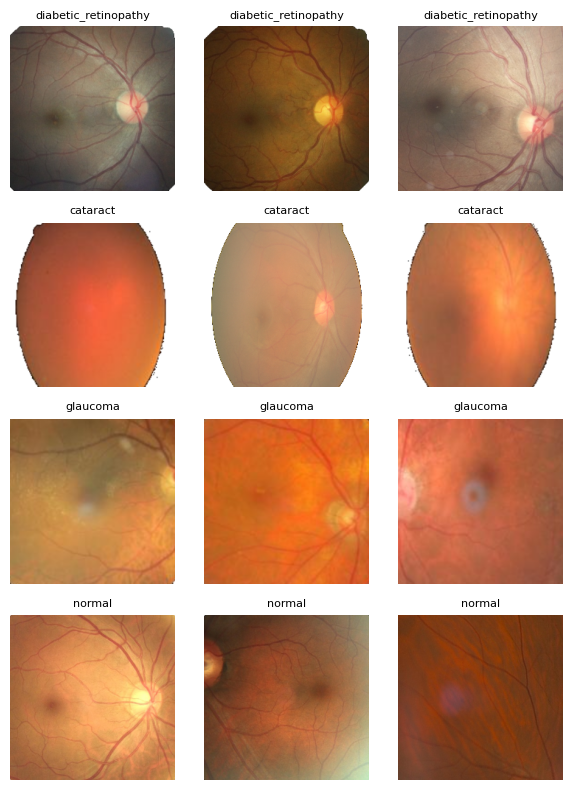

In [ ]:
import cv2, os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf

folder = "/content/eyeimage/eyeimage"
img_size = (224,224)
zoom = 0.7 # Less zoomed
images_per_class = 3

def prep(path):
    img = cv2.imread(path)
    if img is None: return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    bg = np.full(img.shape,255,np.uint8)
    img = cv2.add(cv2.bitwise_and(img,img,mask=mask),
                  cv2.bitwise_and(bg,bg,mask=255-mask))
    img = tf.image.central_crop(img, zoom).numpy().astype(np.uint8)
    img = cv2.resize(img, img_size)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
classes = os.listdir(folder)
plt.figure(figsize=(6,len(classes)*2))  # Fixed size
for i, cls in enumerate(classes):
    for j, f in enumerate(os.listdir(os.path.join(folder,cls))[:images_per_class]):
        plt.subplot(len(classes), images_per_class, i*images_per_class + j + 1)
        plt.imshow(prep(os.path.join(folder,cls,f)))
        plt.title(cls, fontsize=8)
        plt.axis('off')
plt.tight_layout()
plt.show()


Found 4217 files belonging to 4 classes.


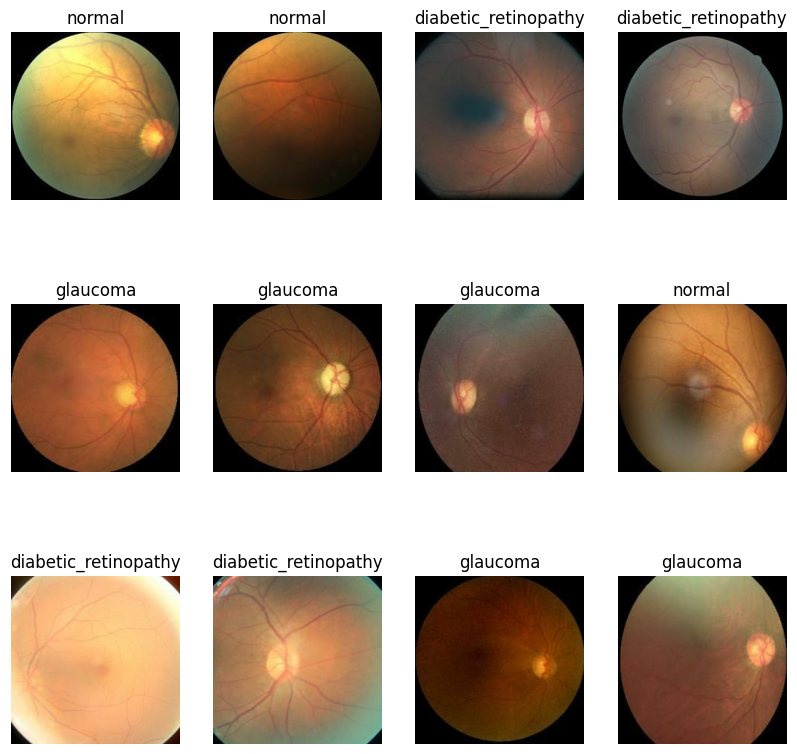

In [ ]:
# Create dataset from directory
dataset_path = '/content/eyeimage/eyeimage'
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Get class names
class_names = dataset.class_names

# Visualize dataset
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

plt.show()

In [ ]:
def crop_eye_circle(dataset_path):
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.png')):
                    img_path = os.path.join(class_path, img_file)

                    # Read image
                    img = cv2.imread(img_path)
                    h, w = img.shape[:2]

                    # Create circular mask
                    center = (w//2, h//2)
                    radius = min(w, h) // 3  # Adjust radius as needed

                    mask = np.zeros((h, w), dtype=np.uint8)
                    cv2.circle(mask, center, radius, 255, -1)

                    # Apply mask and crop
                    result = cv2.bitwise_and(img, img, mask=mask)

                    # Find bounding box of non-zero pixels
                    coords = cv2.findNonZero(mask)
                    x, y, w2, h2 = cv2.boundingRect(coords)
                    cropped = result[y:y+h2, x:x+w2]

                    # Save cropped image
                    cv2.imwrite(img_path, cropped)

# Execute
dataset_path = '/content/eyeimage/eyeimage'
crop_eye_circle(dataset_path)
print("Eye regions cropped!")

Eye regions cropped!


Found 4217 files belonging to 4 classes.


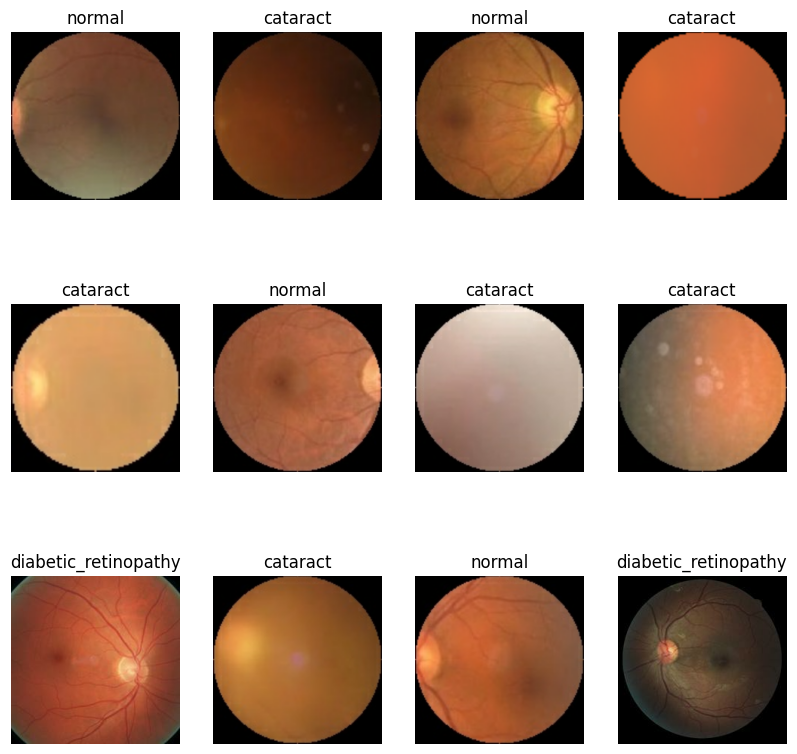

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis("off")
plt.show()

In [ ]:
import os
import shutil
import random

# Create folders and split dataset
for folder in ['train', 'validation', 'test']:
    os.makedirs(f'/content/{folder}', exist_ok=True)

print("Dataset Split Summary:")
print("=" * 40)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_count = int(0.7 * total)
        val_count = int(0.2 * total)
        test_count = total - train_count - val_count

        print(f"{class_name}: {total} total")
        print(f"  Train: {train_count} (70%)")
        print(f"  Validation: {val_count} (20%)")
        print(f"  Test: {test_count} (10%)")

        for folder in ['train', 'validation', 'test']:
            os.makedirs(f'/content/{folder}/{class_name}', exist_ok=True)

        for i, img in enumerate(images):
            src = os.path.join(class_path, img)
            if i < train_count:
                dst = f'/content/train/{class_name}/{img}'
            elif i < train_count + val_count:
                dst = f'/content/validation/{class_name}/{img}'
            else:
                dst = f'/content/test/{class_name}/{img}'
            shutil.copy2(src, dst)

print("\nSplit complete! 70% train, 20% validation, 10% test")

Dataset Split Summary:
diabetic_retinopathy: 1098 total
  Train: 768 (70%)
  Validation: 219 (20%)
  Test: 111 (10%)
cataract: 1038 total
  Train: 726 (70%)
  Validation: 207 (20%)
  Test: 105 (10%)
glaucoma: 1007 total
  Train: 704 (70%)
  Validation: 201 (20%)
  Test: 102 (10%)
normal: 1074 total
  Train: 751 (70%)
  Validation: 214 (20%)
  Test: 109 (10%)

Split complete! 70% train, 20% validation, 10% test


In [ ]:
##data agumentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Create augmented folder
os.makedirs('/content/augmented', exist_ok=True)

# Disease-focused augmentation (zoom in on eye center)
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=[1.2, 1.8],  # Zoom into disease area
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generate augmented images
for class_name in os.listdir('/content/train'):
    os.makedirs(f'/content/augmented/{class_name}', exist_ok=True)

    dataset = tf.keras.utils.image_dataset_from_directory(
        '/content/train',
        class_names=[class_name],
        image_size=(224, 224),
        batch_size=1,
        shuffle=False
    )

    count = 0
    for images, labels in dataset:
        if count >= 30:  # 30 augmented per class
            break

        img_array = images[0].numpy().astype("uint8")
        img_array = img_array.reshape((1,) + img_array.shape)

        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype("uint8")

        tf.keras.utils.save_img(
            f'/content/augmented/{class_name}/aug_{count}.jpg',
            aug_img
        )
        count += 1

print("Disease-focused augmentation complete!")

Found 1071 files belonging to 1 classes.
Found 1010 files belonging to 1 classes.
Found 984 files belonging to 1 classes.
Found 1044 files belonging to 1 classes.
Disease-focused augmentation complete!


Found 1200 files belonging to 4 classes.


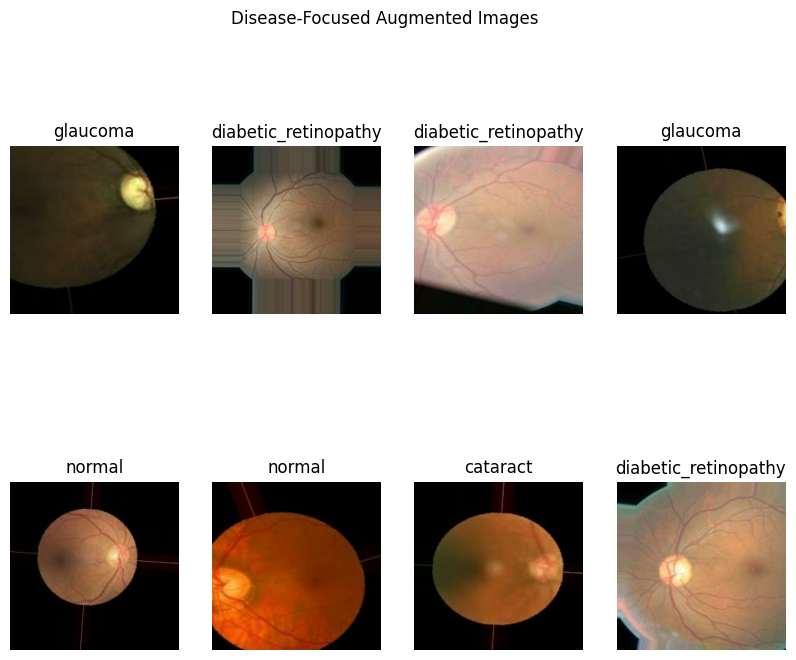

In [ ]:
# Quick visualization
import matplotlib.pyplot as plt

aug_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented', image_size=(224, 224), batch_size=32, shuffle=True
)

plt.figure(figsize=(10, 8))
for image_batch, label_batch in aug_dataset.take(1):
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(aug_dataset.class_names[label_batch[i]])
        plt.axis("off")
plt.suptitle('Disease-Focused Augmented Images')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    '/content/validation',
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical'
)

# Build model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training phase 1...")
model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# Fine-tune
print("Training phase 2 (fine-tuning)...")
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

Found 4109 images belonging to 4 classes.
Found 2061 images belonging to 4 classes.
Training phase 1...
Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1810s 7s/step - accuracy: 0.2516 - loss: 1.4278 - val_accuracy: 0.2431 - val_loss: 1.3865
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1736s 7s/step - accuracy: 0.2241 - loss: 1.3865 - val_accuracy: 0.2581 - val_loss: 1.3861
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1749s 7s/step - accuracy: 0.2506 - loss: 1.3864 - val_accuracy: 0.2581 - val_loss: 1.3861
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1767s 7s/step - accuracy: 0.2655 - loss: 1.3860 - val_accuracy: 0.2581 - val_loss: 1.3861
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1748s 7s/step - accuracy: 0.2515 - loss: 1.3868 - val_accuracy: 0.2581 - val_loss: 1.3861
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1760s 7s/step - accuracy: 0.2654 - loss: 1.3858 - val_accuracy: 0.2581 - val_loss: 1.3861
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1744s 7s/step - accuracy: 0.2547 - loss: 1.3867 - val_accuracy: 0.2581 - val

In [14]:
############################## NEW CODEEE

In [17]:
# 1. Import necessary libraries
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
# Install the required libraries
!pip install timm
!pip install albumentations
!pip install timm albumentations opencv-python
import re
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
import pickle

# Install wandb if you want to use it for logging
# !pip install wandb

In [16]:
# 2. Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 3. Import necessary libraries
import zipfile
import os
import re
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
import shutil
import cv2
import hashlib

In [19]:
# 4. Set paths and extract data
zip_path = '/content/drive/MyDrive/Frenita (1)/eyeimage.zip' # Make sure this path is correct
extract_dir = '/content/data'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Dataset extracted to:", extract_dir)

Dataset extracted to: /content/data


In [23]:
# 5. Data Preparation and Cleaning
data_dir = os.path.join(extract_dir, "eyeimage")
records = []
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)

            # Check for corrupted images
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Skipping corrupted image: {img_path}")
                    continue
            except Exception as e:
                print(f"Skipping image due to error: {img_path}, {e}")
                continue

            # **CORRECTED FIX:** Extract patient_id robustly
            # This handles both "ID_..." and simple numerical filenames
            patient_id_match = re.search(r'(\d+)', img_name)
            if patient_id_match:
                patient_id = patient_id_match.group(1)
            else:
                # Assign a generic ID if no number is found, to prevent empty records list
                patient_id = 'unknown'

            records.append({
                "path": img_path,
                "label": label,
                "img_name": img_name,
                "patient_id": patient_id
            })

df = pd.DataFrame(records)
print(f"Initial dataset size: {len(df)}")

# Check for and remove duplicates using MD5 hash
def get_hash(path):
    # Check if the file exists before attempting to open it
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    return None # Return None for non-existent files

df['md5'] = df['path'].apply(get_hash)
df.drop_duplicates(subset='md5', keep='first', inplace=True)
print(f"Dataset size after removing duplicates: {len(df)}")

Initial dataset size: 4217
Dataset size after removing duplicates: 4215


In [25]:
# 6. Perform Patient-based Stratified K-Fold split (no patient leakage)
patient_df = df.drop_duplicates(subset='patient_id')[['patient_id', 'label']]

# **FIX:** Reset the index to ensure it is continuous before the split
patient_df = patient_df.reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
patient_df['fold'] = -1

# The split now correctly uses the new sequential index
for fold, (train_idx, val_idx) in enumerate(skf.split(patient_df, patient_df['label'])):
    patient_df.loc[val_idx, 'fold'] = fold

patient_fold_dict = dict(zip(patient_df['patient_id'], patient_df['fold']))
df['fold'] = df['patient_id'].map(patient_fold_dict)
df.to_csv("/content/data_split/folds.csv", index=False)
print("Stratified 5-fold CSV saved")
print(df.groupby(["fold", "label"]).size())

Stratified 5-fold CSV saved
fold  label               
0     cataract                205
      diabetic_retinopathy    224
      glaucoma                193
      normal                  211
1     cataract                219
      diabetic_retinopathy    220
      glaucoma                210
      normal                  213
2     cataract                192
      diabetic_retinopathy    218
      glaucoma                200
      normal                  221
3     cataract                196
      diabetic_retinopathy    216
      glaucoma                198
      normal                  213
4     cataract                224
      diabetic_retinopathy    220
      glaucoma                206
      normal                  216
dtype: int64


In [26]:
# 7. Create train and test directories and copy files
base_dir = "/content/data_split"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_df = df[df['fold'] != 0]
test_df = df[df['fold'] == 0]

print("Copying training images...")
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    dest_path = os.path.join(train_dir, row['label'], row['img_name'])
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    shutil.copy(row['path'], dest_path)

print("Copying testing images...")
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    dest_path = os.path.join(test_dir, row['label'], row['img_name'])
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    shutil.copy(row['path'], dest_path)

print("Finished splitting data and copying files.")
print(f"Number of images in training set: {len(train_df)}")
print(f"Number of images in testing set: {len(test_df)}")

Copying training images...


  0%|          | 0/3382 [00:00<?, ?it/s]

Copying testing images...


  0%|          | 0/833 [00:00<?, ?it/s]

Finished splitting data and copying files.
Number of images in training set: 3382
Number of images in testing set: 833


In [28]:
##4 — Preprocessing & augmentations (train / val / TTA)

In [27]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [29]:
# Define the image size and standard normalization values
IMAGE_SIZE = 384
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [33]:
# Training transforms with both weak and strong augmentations
train_transforms = A.Compose([
    # FIX: Pass a single `size` tuple to resolve the ValidationError
    A.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=15),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
    A.GaussianBlur(p=0.2, blur_limit=(3, 7)),
    A.OneOf([
        A.GaussNoise(),
        A.ImageCompression(quality_lower=85, quality_upper=95)
    ], p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])


/tmp/ipython-input-3033200935.py:13: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=95)


In [35]:
# Validation transforms
val_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])


In [36]:
# Test-Time Augmentation (TTA) transforms
# Pass height and width here as well for consistency
tta_hflip = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

tta_rotate_pos = A.Compose([
    A.Rotate(limit=(15, 15), p=1.0),
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

tta_rotate_neg = A.Compose([
    A.Rotate(limit=(-15, -15), p=1.0),
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])